# Training and testing with different classifiers

This notebook contains code to apply different ml models to the pre-processed recipe-ingredient dataset. For pre-processing, check the other notebook.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import WordNetLemmatizer
import inflect

Loading the dataset based on understanding of previous EDA.
Lemmatizing instead of stemming to preserve context - in terms of recipe, baked potatoes (potatoes that are already baked) vs baking potatoes (a variety of potatoes) are different. Stemming would result in both 'baked' and 'baking' being converted to 'bake' which is incorrect whereas lemmatizing preserves the terms.

Using inflect to remove plural forms (since baked potato and baked potatoes do need to be the considered the 'same').

In [3]:
df = pd.read_json('dataset.json')

wn = WordNetLemmatizer() # lemmatizing instead of stemming to preserve context
p = inflect.engine() # to change to singular instead of stemming

def format_ingredients(ingredient_list):
    formatted = [ing.strip().lower() for ing in ingredient_list]
    singular = [p.singular_noun(ing) or ing for ing in formatted]
    lemmatized = [wn.lemmatize(ing) for ing in singular]
    return (', '.join(lemmatized))

df['ingredients_formatted'] = df['ingredients'].apply(lambda x: format_ingredients(x))
print(df.head(10))

      id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   
5   6602     jamaican  [plain flour, sugar, butter, eggs, fresh ginge...   
6  42779      spanish  [olive oil, salt, medium shrimp, pepper, garli...   
7   3735      italian  [sugar, pistachio nuts, white almond bark, flo...   
8  16903      mexican  [olive oil, purple onion, fresh pineapple, por...   
9  12734      italian  [chopped tomatoes, fresh basil, garlic, extra-...   

                               ingredients_formatted  
0  romaine lettuce, black olive, grape tomato, ga...  
1  plain flour, ground pepper, salt, tomato, grou... 

### Vectorizing

The ingredient list is already tokenized (as an array of ingredients), but needs to be vectorized (i.e. encoded so as to be able to create feature vectors for the machine learning algorithms to train/test)


There are three main forms of vectorizing for NLP:
* Bag-of-words - creates a 'bag of words' with a document matrix count with 1 if present and 0 if not. Not very suitable/efficient in terms of storage/accessibility since there are 6000+ types of ingredients as evidenced by EDA.
* N-grams - combinations of adjacent words, not useful in this context since there are unique clusters already.
* TF-IDF - Computer 'relative frequency', useful for identifying important words, or in our case key ingredients that could potentially identify the type of cuisine. 

Apply TF-IDF vectorization on the dataset.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,4), analyzer='word', max_df=0.8, token_pattern=r'\w+')
x_tfidf = tfidf.fit_transform(df['ingredients_formatted'])
print(x_tfidf.shape)

(39774, 747018)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x_tfidf, df['cuisine'], random_state=42)

# clf = KNeighborsClassifier()
# clf.fit(x_train, y_train)
# print(f'Training >> {clf.score(x_train, y_train)}') #74.35
# print(f'Testing >> {clf.score(x_test, y_test)}') #60.8
scores = []
for i in range(1,21):
    clf = KNeighborsClassifier(i)
    clf.fit(x_train, y_train)
    scores.append([i, clf.score(x_train, y_train), clf.score(x_test, y_test)])

score_df = pd.DataFrame(scores, columns=['K', 'Training', 'Testing'])
print(score_df)

     K  Training   Testing
0    1  0.999899  0.545756
1    2  0.767717  0.522124
2    3  0.759906  0.572104
3    4  0.750955  0.593323
4    5  0.743580  0.608307
5    6  0.734898  0.619570
6    7  0.726819  0.627112
7    8  0.720986  0.630933
8    9  0.717231  0.633045
9   10  0.712437  0.641593
10  11  0.709923  0.643302
11  12  0.708079  0.647828
12  13  0.704794  0.646521
13  14  0.701643  0.649739
14  15  0.702112  0.648833
15  16  0.698525  0.650342
16  17  0.697586  0.649739
17  18  0.695441  0.650141
18  19  0.694066  0.650744
19  20  0.693128  0.649839


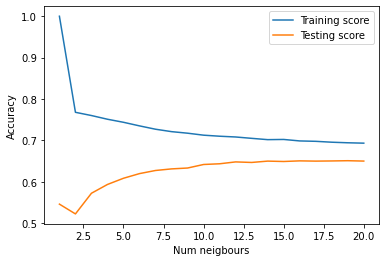

In [6]:
plt.plot(range(1,21), score_df['Training'], label='Training score')
plt.plot(range(1,21), score_df['Testing'], label='Testing score')
plt.ylabel('Accuracy')
plt.xlabel('Num neigbours')
plt.legend()
plt.savefig('SS_for_report/KNN_choosing_k.png')

     K  Training   Testing
0    5  0.743580  0.608307
1    6  0.734898  0.619570
2    7  0.726819  0.627112
3    8  0.720986  0.630933
4    9  0.717231  0.633045
5   10  0.712437  0.641593
6   11  0.709923  0.643302
7   12  0.708079  0.647828
8   13  0.704794  0.646521
9   14  0.701643  0.649739
10  15  0.702112  0.648833
11  16  0.698525  0.650342
12  17  0.697586  0.649739
13  18  0.695441  0.650141
14  19  0.694066  0.650744
15  20  0.693128  0.649839
16  21  0.692457  0.651247
17  22  0.691116  0.651649
18  23  0.690077  0.652957
19  24  0.688300  0.653057


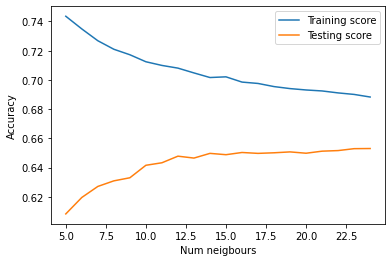

In [7]:

# clf = KNeighborsClassifier()
# clf.fit(x_train, y_train)
# print(f'Training >> {clf.score(x_train, y_train)}') #74.35
# print(f'Testing >> {clf.score(x_test, y_test)}') #60.8
scores = []
for i in range(5,25):
    clf = KNeighborsClassifier(i)
    clf.fit(x_train, y_train)
    scores.append([i, clf.score(x_train, y_train), clf.score(x_test, y_test)])

score_df = pd.DataFrame(scores, columns=['K', 'Training', 'Testing'])
print(score_df)

plt.plot(range(5,25), score_df['Training'], label='Training score')
plt.plot(range(5,25), score_df['Testing'], label='Testing score')
plt.ylabel('Accuracy')
plt.xlabel('Num neigbours')
plt.legend()
plt.savefig('SS_for_report/KNN_choosing_k.png')